In [67]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('/Users/mariana/Documents/research/xlstm-jax')

# Force CPU (optional)
jax.config.update("jax_platform_name", "cpu")

from xlstm_jax.models.xlstm_clean.blocks.mlstm.backend.simple import (
    parallel_stabilized_simple,
    recurrent_step_stabilized_simple,
)

B, NH, S, DH = 1, 2, 8, 16
q = jax.random.normal(jax.random.key(0), (B, NH, S, DH))
k = jax.random.normal(jax.random.key(1), (B, NH, S, DH))
v = jax.random.normal(jax.random.key(2), (B, NH, S, DH))
igate = jnp.zeros((B, NH, S, 1))
fgate = jnp.zeros((B, NH, S, 1))

y = parallel_stabilized_simple(q, k, v, igate, fgate)  # (B, NH, S, DH)
print(y.shape)

(1, 2, 8, 16)


In [68]:
from dataclasses import dataclass
from flax import linen as nn

from xlstm_jax.models.xlstm_clean.components.init import small_init
from xlstm_jax.models.xlstm_clean.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.block import xLSTMBlockConfig, mLSTMBlockConfig
from xlstm_jax.models.xlstm_clean.blocks.mlstm.cell import mLSTMBackendNameAndKwargs
from xlstm_jax.models.xlstm_clean.blocks.mlstm.layer import mLSTMCellConfig, mLSTMLayerConfig
from xlstm_jax.models.xlstm_clean.components.feedforward import FeedForwardConfig

In [69]:
@dataclass
class xLSTMTabModelConfig(xLSTMBlockStackConfig):
    embedding_dim: int = 16
    tie_weights: bool = False
    weight_decay_on_embedding: bool = False
    add_embedding_dropout: bool = True
    output_dim: int = 1

class xLSTMTabModel(nn.Module):
    config: xLSTMTabModelConfig

    @nn.compact
    def __call__(self, x: jax.Array, train: bool = False) -> jax.Array:
        x = nn.Dense(
            features=self.config.embedding_dim,
            kernel_init=small_init(self.config.embedding_dim),
            dtype=self.config._dtype,
            name="token_embedding",
        )(x)
        pos_emb = self.param(
            "pos_embedding",
            nn.initializers.normal(stddev=0.02),
            (self.config.context_length, self.config.embedding_dim),
        )
        x = x + pos_emb[:x.shape[1]]
        if self.config.add_embedding_dropout:
            x = nn.Dropout(rate=self.config.dropout)(x, deterministic=not train)
        x = xLSTMBlockStack(config=self.config, name="xlstm_block_stack")(x, train=train)
        logits = nn.Dense(
            features=self.config.output_dim,
            kernel_init=small_init(self.config.embedding_dim),
            use_bias=False,
            dtype=jnp.float32,
            name="pred_head",
        )(x)
        return logits

In [70]:
# config = xLSTMTabModelConfig(
#             embedding_dim=16,
#             num_blocks=12,
#             context_length=32,
#             tie_weights=False,
#             add_embedding_dropout=False,
#             add_post_blocks_norm=True,
#             dtype="bfloat16",
#             mlstm_block=mLSTMBlockConfig(
#                 mlstm=mLSTMLayerConfig(
#                     num_heads=4,
#                     mlstm_cell=mLSTMCellConfig(
#                         backend=mLSTMBackendNameAndKwargs(name="parallel_stabilized")
#                     ),
#                 )
#             ),
#         )

In [76]:
@dataclass
class ModelConfig:
    batch_size: int = 1
    embedding_dim: int = 16
    num_blocks: int = 2
    num_heads: int = 2
    context_length: int = 32
    backend: str = "parallel_stabilized"
    backend_name: str = ""

cfg = ModelConfig(
    batch_size=16,
)

dtype_str = "float32"
xlstm_config = xLSTMTabModelConfig(
    embedding_dim=cfg.embedding_dim,
    num_blocks=cfg.num_blocks,
    context_length=cfg.context_length,
    tie_weights=False,
    add_embedding_dropout=False,
    add_post_blocks_norm=True,
    dtype="bfloat16",
    mlstm_block=xLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4,
            qkv_proj_blocksize=4,
            num_heads=4,
            proj_factor=2.0,
            embedding_dim=cfg.embedding_dim,
            bias=True,
            dropout=0.2,
            context_length=cfg.context_length,
            dtype="bfloat16",
        ),
        _num_blocks=1,
        _block_idx=0,
        feedforward=FeedForwardConfig(
            proj_factor=4.0,
            embedding_dim=cfg.embedding_dim,
            dropout=0.2,
            dtype="bfloat16",
        ),
    ),
)

In [72]:
xlstm = xLSTMTabModel(config=xlstm_config)
rng = jax.random.PRNGKey(42)
param_rng, dropout_rng = jax.random.split(rng)

B, S, D = 16, 32, 1

batch_input = jnp.ones((1, S, D))

params = xlstm.init({"params": param_rng, "dropout": dropout_rng}, batch_input)
sum(jnp.size(p) for p in jax.tree_util.tree_leaves(params))

12272

In [57]:
# # Loading data using signature survival
# sys.path.append('/Users/mariana/Documents/others_code/signature_survival')
# from data_loader import load_OU
# paths, surv_labels, ddh_info_sup = load_OU.load()
# n_samples, n_sampling_times, _ = paths.shape
# sampling_times = paths[0, :, 0]
# surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]
# paths_init = paths.clone() # for MC true survival function

# # TODO: turn datagen into JAX

In [1]:
from scipy.special import expit as sigmoid
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Borrowed from tdsurv (https://github.com/spotify-research/tdsurv/blob/main/notebooks/random-walk-final.ipynb)
def make_generator(mat, sigma, sigma0, thetas, bias, rng):
    """Sample from a Gauss-Markov process.
    
    Initial state:
    
        x_0 = noise(sigma0)
    
    Transition dynamics:
    
        x_nxt = np.dot(mat, x) + noise(sigma)
        
    Churn probability:
    
        p = sigmoid(np.dot(x, thetas) + bias)
    """
    n_dims = mat.shape[0]
    def gen(n_samples, horizon):
        seqs = np.zeros((n_samples, horizon + 1, n_dims + 1))
        ts = np.zeros(n_samples, dtype=int)
        cs = np.zeros(n_samples, dtype=bool)
        for i in range(n_samples):
            seqs[i, 0] = np.append(sigma0 * rng.normal(size=n_dims), 1)
            ts[i] = 1
            for j in range(0, horizon):
                p = sigmoid(np.dot(seqs[i, j, :-1], thetas) + bias)
                if rng.uniform() < p:
                    break
                ts[i] += 1
                seqs[i, j + 1] = np.append(
                    np.dot(mat, seqs[i, j, :-1]) + sigma * rng.normal(size=n_dims),
                    1,
                )
            if ts[i] > horizon:
                ts[i] = horizon
                cs[i] = True
        return seqs.astype(np.float32), ts, cs
    return gen

In [51]:
rng = np.random.default_rng(seed=0)

n_dims = 1
horizon = 99
d = n_dims
H = horizon 

# Churn parameters.
thetas = rng.normal(size=n_dims)
bias = -4

# Transition dynamics.
mat = 1.0 * np.eye(n_dims)
sigma = 0.5
sigma0 = 1.0 # Affect results quite a lot


gen = make_generator(mat, sigma, sigma0, thetas, bias, rng)
seqs, ts, cs = gen(n_samples=1000, horizon=horizon)

In [52]:
seqs.shape

(1000, 100, 2)

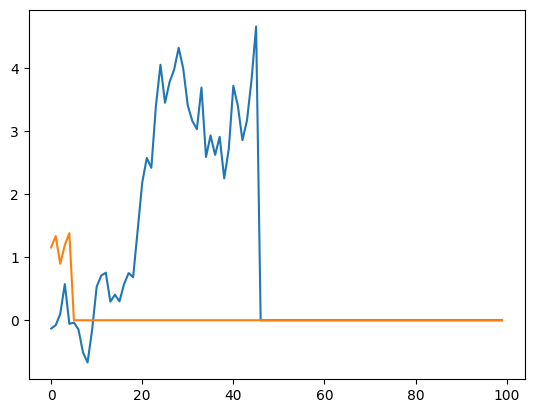

In [64]:
plt.plot(seqs[0][:,0])
plt.plot(seqs[10][:,0])

In [65]:
cs.sum()/len(cs)

0.188

In [113]:
# Training setup
import optax

S = 32  # context length (fixed for the model)

# Dataset: generate long sequences and chunk them with sliding window
class ChunkedDataset:
    """Generate long sequences and yield chunks via sliding window."""
    
    def __init__(self, gen_fn, n_seqs=100, horizon=200, chunk_size=32, stride=1):
        self.gen_fn = gen_fn
        self.chunk_size = chunk_size
        self.stride = stride
        self.refresh(n_seqs, horizon)
    
    def refresh(self, n_seqs=100, horizon=200):
        """Generate new sequences and extract chunks."""
        seqs, _, _ = self.gen_fn(n_samples=n_seqs, horizon=horizon)
        self.all_chunks_x = []
        self.all_chunks_mask = []
        
        for i in range(len(seqs)):
            seq_x = seqs[i, :, :1]      # (L, 1) - values
            seq_mask = seqs[i, :, -1]   # (L,) - validity mask
            valid_len = int(seq_mask.sum())
            
            # Extract chunks using sliding window (only from valid region)
            for start in range(0, max(1, valid_len - self.chunk_size + 1), self.stride):
                end = start + self.chunk_size
                if end <= valid_len:
                    self.all_chunks_x.append(seq_x[start:end])
                    self.all_chunks_mask.append(seq_mask[start:end])
        
        self.all_chunks_x = np.array(self.all_chunks_x)      # (N_chunks, chunk_size, 1)
        self.all_chunks_mask = np.array(self.all_chunks_mask) # (N_chunks, chunk_size)
        print(f"Created {len(self.all_chunks_x)} chunks from {n_seqs} sequences")
    
    def sample_batch(self, batch_size, rng_key=None):
        """Sample a random batch of chunks."""
        if rng_key is None:
            idx = np.random.choice(len(self.all_chunks_x), size=batch_size, replace=True)
        else:
            idx = jax.random.choice(rng_key, len(self.all_chunks_x), shape=(batch_size,), replace=True)
        return self.all_chunks_x[idx], self.all_chunks_mask[idx]

# Create dataset
dataset = ChunkedDataset(gen, n_seqs=200, horizon=150, chunk_size=S, stride=1)

# Initialize model
xlstm = xLSTMTabModel(config=xlstm_config)
rng = jax.random.PRNGKey(42)
param_rng, dropout_rng = jax.random.split(rng)
params = xlstm.init({"params": param_rng, "dropout": dropout_rng}, jnp.ones((1, S, 1)))

Created 5701 chunks from 200 sequences


In [115]:
# Loss: MSE for next-token prediction with padding mask
def loss_fn(params, x, mask, rng):
    """
    x: (B, S, 1) - input sequence of EXACTLY context_length
    mask: (B, S) - 1 where valid, 0 where padded
    
    Next-token prediction: pred[t] predicts x[t+1]
    Loss computed only where BOTH input[t] AND target[t+1] are valid.
    
    Example with padding=3:
      Input:  [0,   0,   0,   x_0, x_1, x_2, x_3, x_4]
      Target: [0,   0,   x_0, x_1, x_2, x_3, x_4, ???]  (shifted)
      Mask:   [0,   0,   0,   1,   1,   1,   1,   1]
      
      Loss only at positions 3-6 where input is valid:
        - pos 3: given x_0, predict x_1
        - pos 4: given x_0,x_1, predict x_2
        - etc.
    """
    preds = xlstm.apply(params, x, train=True, rngs={"dropout": rng})  # (B, S, 1)
    
    # Masks for valid positions
    input_mask = mask[:, :-1]   # (B, S-1) - is input at position t valid?
    target_mask = mask[:, 1:]   # (B, S-1) - is target at position t+1 valid?
    combined_mask = input_mask * target_mask  # both must be valid
    
    squared_errors = (preds[:, :-1, 0] - x[:, 1:, 0]) ** 2  # (B, S-1)
    masked_errors = squared_errors * combined_mask
    
    # Mean over valid positions only
    return jnp.sum(masked_errors) / (jnp.sum(combined_mask) + 1e-8)

# Training step
@jax.jit
def train_step(params, opt_state, x, mask, rng):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, mask, rng)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [116]:
# Training loop with proper random left-padding (SHIFT, not mask)
n_steps = 500
batch_size = 32
rng = jax.random.PRNGKey(0)

def apply_random_left_padding(x, mask, rng_key, min_context=8):
    """
    Randomly left-pad sequences to simulate shorter contexts.
    
    With padding=k:
      Original: [x_0, x_1, x_2, ..., x_{S-1}]
      Padded:   [0, 0, ..., 0, x_0, x_1, ..., x_{S-k-1}]
                 └─ k zeros ─┘ └── first (S-k) elements ──┘
    
    x: (B, S, 1)
    mask: (B, S)
    """
    B, S_len, _ = x.shape
    
    # Random padding amount: 0 to (S - min_context)
    max_padding = S_len - min_context
    padding_amounts = jax.random.randint(rng_key, (B,), minval=0, maxval=max_padding + 1)
    
    x_padded = []
    mask_padded = []
    
    for i in range(B):
        pad = int(padding_amounts[i])
        if pad > 0:
            # Take FIRST (S - pad) elements, left-pad with zeros
            x_shifted = jnp.concatenate([
                jnp.zeros((pad, 1)),           # left padding (zeros)
                x[i, :S_len - pad, :]          # first (S - pad) elements
            ], axis=0)
            mask_shifted = jnp.concatenate([
                jnp.zeros(pad),                # padding positions → mask=0
                mask[i, :S_len - pad]          # validity for kept elements
            ], axis=0)
        else:
            x_shifted = x[i]
            mask_shifted = mask[i]
        
        x_padded.append(x_shifted)
        mask_padded.append(mask_shifted)
    
    return jnp.stack(x_padded), jnp.stack(mask_padded)

for step in range(n_steps):
    # Sample batch from chunked dataset
    x_batch, mask_batch = dataset.sample_batch(batch_size)
    x_batch = jnp.array(x_batch)
    mask_batch = jnp.array(mask_batch)
    
    # Apply random left-padding (shift) 50% of the time
    rng, pad_rng, step_rng, choice_rng = jax.random.split(rng, 4)
    if jax.random.uniform(choice_rng) < 0.5:
        x_batch, mask_batch = apply_random_left_padding(x_batch, mask_batch, pad_rng)
    
    params, opt_state, loss = train_step(params, opt_state, x_batch, mask_batch, step_rng)
    
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss:.6f}")

Step 0, Loss: 11.115305
Step 100, Loss: 5.294189
Step 200, Loss: 10.355308
Step 300, Loss: 3.103230
Step 400, Loss: 0.606174


In [117]:
# Causality test: verify no future leakage
# If we change future values, predictions at earlier timesteps should NOT change

def test_no_future_leakage():
    """
    Test that predictions at time t don't depend on inputs at time > t.
    This verifies the model is truly causal (no information leakage from the future).
    """
    seqs_test, _, _ = gen(n_samples=1, horizon=S)
    x_orig = jnp.array(seqs_test[:, :S, :1])  # (1, S, 1) - exactly context_length
    
    # Get predictions with original input
    preds_orig = xlstm.apply(params, x_orig, train=False)
    
    # Modify future values (last 10 timesteps) with a large perturbation
    x_modified = x_orig.at[:, -10:, :].set(x_orig[:, -10:, :] + 100.0)
    preds_modified = xlstm.apply(params, x_modified, train=False)
    
    # Predictions for early timesteps (before modification) should be IDENTICAL
    # because causal models can only see past, not future
    early_diff = jnp.abs(preds_orig[:, :-10, :] - preds_modified[:, :-10, :]).max()
    
    if early_diff < 1e-5:
        print("✓ Causality test PASSED: No future leakage detected")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    else:
        print("✗ Causality test FAILED: Future information is leaking!")
        print(f"  Max diff in early predictions: {early_diff:.2e}")
    
    return early_diff < 1e-5

test_no_future_leakage()

✓ Causality test PASSED: No future leakage detected
  Max diff in early predictions: 0.00e+00


Array(True, dtype=bool)

In [118]:
# Evaluation on test set (fresh sequences, not seen during training)
def evaluate(params, gen_fn, n_seqs=50, horizon=150, chunk_size=S):
    """Evaluate model on fresh test sequences."""
    # Generate new test sequences
    test_dataset = ChunkedDataset(gen_fn, n_seqs=n_seqs, horizon=horizon, 
                                   chunk_size=chunk_size, stride=chunk_size)
    
    x_test = jnp.array(test_dataset.all_chunks_x)
    mask_test = jnp.array(test_dataset.all_chunks_mask)
    
    preds = xlstm.apply(params, x_test, train=False)
    
    # Masked test loss (same logic as training: both input AND target must be valid)
    input_mask = mask_test[:, :-1]
    target_mask = mask_test[:, 1:]
    combined_mask = input_mask * target_mask
    
    squared_errors = (preds[:, :-1, 0] - x_test[:, 1:, 0]) ** 2
    test_loss = jnp.sum(squared_errors * combined_mask) / (jnp.sum(combined_mask) + 1e-8)
    
    return test_loss, x_test, mask_test, preds

test_loss, x_test, mask_test, preds_test = evaluate(params, gen)
print(f"Test MSE: {test_loss:.6f}")

Created 50 chunks from 50 sequences
Test MSE: 0.907962


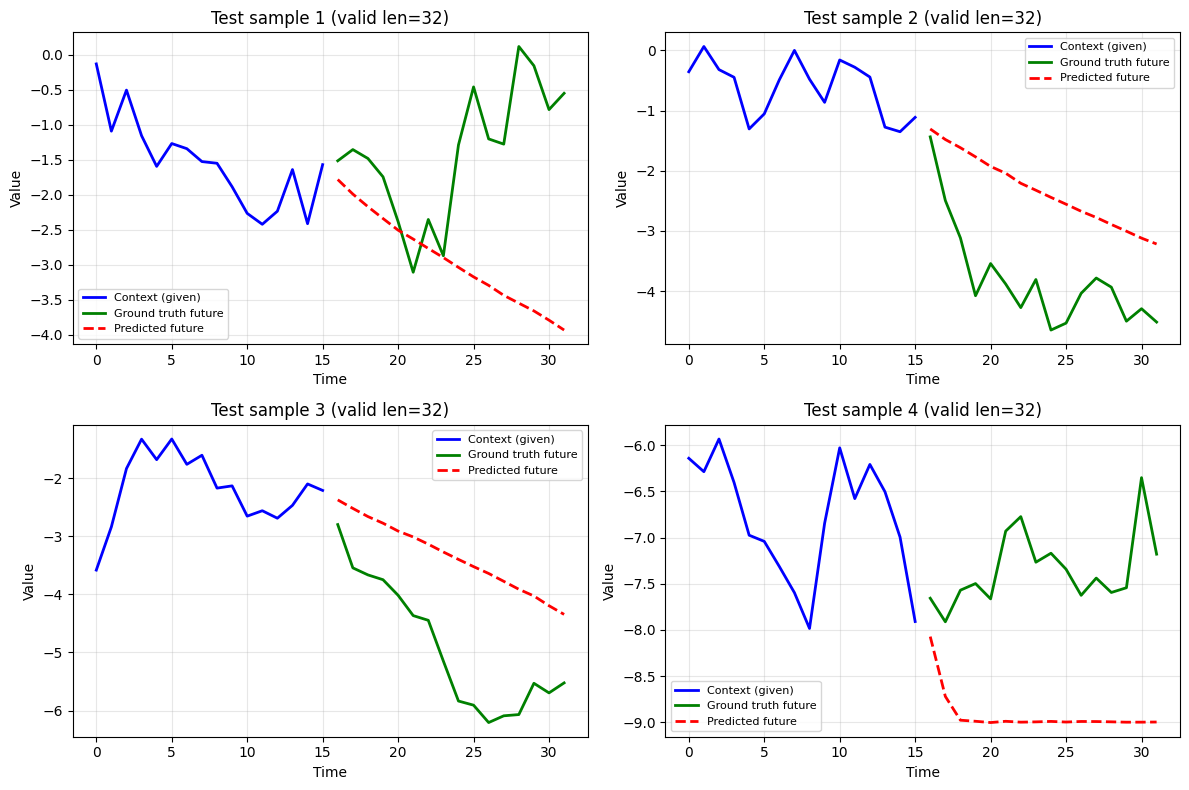

In [119]:
# Autoregressive forecasting from a fixed context
def autoregressive_forecast(params, context, n_future, full_seq_len=S):
    """
    Given an initial context, autoregressively predict n_future steps.
    context: (1, context_len, 1) - initial input (can be < full_seq_len)
    
    Uses LEFT-PADDING: context sits at the end of the input window.
    This way, the prediction at the last position forecasts the next token.
    """
    context_len = context.shape[1]
    predictions = []
    
    # Left-pad to full sequence length if needed
    if context_len < full_seq_len:
        padding = jnp.zeros((1, full_seq_len - context_len, 1))
        current_input = jnp.concatenate([padding, context], axis=1)
    else:
        # If context >= full_seq_len, take the last full_seq_len values
        current_input = context[:, -full_seq_len:, :]
    
    for _ in range(n_future):
        # Predict: output at last position predicts next token
        pred = xlstm.apply(params, current_input, train=False)
        next_val = pred[0, -1, 0]
        predictions.append(float(next_val))
        
        # Slide window: drop first (oldest), append new prediction at end
        current_input = jnp.concatenate([
            current_input[:, 1:, :],
            jnp.array([[[next_val]]])
        ], axis=1)
    
    return np.array(predictions)

# Plot: context + autoregressive forecast vs ground truth
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

context_len = 16  # Use first 16 steps as context
n_future = S - context_len  # Predict the rest

for i, ax in enumerate(axes):
    # Get a test sequence with enough valid data
    seq = np.array(x_test[i, :, 0])
    mask = np.array(mask_test[i, :])
    
    # Context (given input)
    context = x_test[i:i+1, :context_len, :]
    
    # Autoregressive forecast
    forecast = autoregressive_forecast(params, context, n_future)
    
    # Ground truth future
    gt_future = seq[context_len:]
    
    # Find where sequence ends (mask becomes 0)
    valid_len = int(mask.sum())
    
    # Plot
    t_context = np.arange(context_len)
    t_future = np.arange(context_len, S)
    
    ax.plot(t_context, seq[:context_len], 'b-', linewidth=2, label='Context (given)')
    ax.plot(t_future, gt_future, 'g-', linewidth=2, label='Ground truth future')
    ax.plot(t_future, forecast, 'r--', linewidth=2, label='Predicted future')
    
    # Mark where padding starts
    if valid_len < S:
        ax.axvline(x=valid_len, color='gray', linestyle=':', alpha=0.7, label='Seq ends (padding)')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Test sample {i+1} (valid len={valid_len})')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()